#MODELLING


10 genus with 2000 pictures per genus. Different models tested with transfer learning, data augmentation

# Introduction


### Settings

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

GDRIVE_MOUNT_POINT = '/content/drive'
PROJECT_DIR = GDRIVE_MOUNT_POINT + '/MyDrive/Mushroom_project' 
PY_LIB_DIR = PROJECT_DIR + '/src/lib'
SRC_DIR = PROJECT_DIR + '/datasource/mushroomObserver/dataframes/clean'

WORK_DIR = "/content/drive/MyDrive/work/Oliv"
IMG_DIR = WORK_DIR + "/images_clean"

MODEL_DIR = WORK_DIR + "/saved_model/10 genus_2k/"


### Import libraries

In [ ]:
# Importing standard libraries
#
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from keras.preprocessing import image
from tensorflow.keras import models

import cv2
import matplotlib.cm as cm

from IPython.display import Image, display

import random

from sklearn import metrics
from sklearn.model_selection import train_test_split

 

In [ ]:
# Optional - Pre-requisites 
#
# Mounting Google drive if not already done
if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


### Loading Data

In [ ]:
df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

In [ ]:
df_genus.shape

(27080, 39)

In [ ]:
df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

#specify image link within Google Drive
#for i in range(len(df_genus)):
#  df_genus.loc[i,"img_path"]= WORK_DIR + "/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


#filter specific nb of genus for test purposes

filtre_genus=df_genus.taxon_name.value_counts().index[:10]

t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125,  random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)
X_train.head()

shape :  (27080, 39)
shape X genus:  (18560, 2)
shape train:  (12992, 2)
shape test: (3712, 2)
shape valid:  (1856, 2)


,img_path,taxon_name
0,/content/drive/MyDrive/work/Oliv/images_clean/...,Entoloma
1,/content/drive/MyDrive/work/Oliv/images_clean/...,Marasmius
2,/content/drive/MyDrive/work/Oliv/images_clean/...,Marasmius
3,/content/drive/MyDrive/work/Oliv/images_clean/...,Russula
4,/content/drive/MyDrive/work/Oliv/images_clean/...,Entoloma


In [ ]:
df_genus.taxon_name.value_counts()

Amanita        1927
Hygrocybe      1899
Armillaria     1899
Lactarius      1887
Agaricus       1884
Gymnopus       1852
Cortinarius    1837
Russula        1816
Marasmius      1800
Entoloma       1759
Name: taxon_name, dtype: int64

In [ ]:
#Global Configuration

epochs= 100

batch_size=32


#Efficient Net B0

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.01


In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.


In [ ]:
#optionnal : visualise 5 pictures
mushroom=[next(train_generator) for i in range(0,5)]
fig,ax=plt.subplots(1,5, figsize=(15,6))
print("Genre: ", [item[1][0] for item in mushroom])
for i in range(0,5):
    ax[i].imshow(mushroom[i][0][0].astype("uint8"))
    ax[i].axis("off")


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)    #preprocessing treatments included in the model 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)


callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)
# on arrive à %

Epoch 1/100
406/406 [==============================] - 112s 262ms/step - loss: 2.5216 - accuracy: 0.2499 - val_loss: 1.6818 - val_accuracy: 0.4003
Epoch 2/100
406/406 [==============================] - 104s 256ms/step - loss: 1.8923 - accuracy: 0.3384 - val_loss: 1.5269 - val_accuracy: 0.4607
Epoch 3/100
406/406 [==============================] - 106s 260ms/step - loss: 1.7620 - accuracy: 0.3855 - val_loss: 1.5088 - val_accuracy: 0.4704
Epoch 4/100
406/406 [==============================] - 104s 256ms/step - loss: 1.6907 - accuracy: 0.4115 - val_loss: 1.4137 - val_accuracy: 0.5086
Epoch 5/100
406/406 [==============================] - 104s 256ms/step - loss: 1.6282 - accuracy: 0.4308 - val_loss: 1.4308 - val_accuracy: 0.5054
Epoch 6/100
406/406 [==============================] - 105s 259ms/step - loss: 1.5861 - accuracy: 0.4496 - val_loss: 1.3481 - val_accuracy: 0.5286
Epoch 7/100
406/406 [==============================] - 103s 254ms/step - loss: 1.5419 - accuracy: 0.4641 - val_loss: 1

58/58 [==============================] - 571s 10s/step - loss: 1.1460 - accuracy: 0.6018


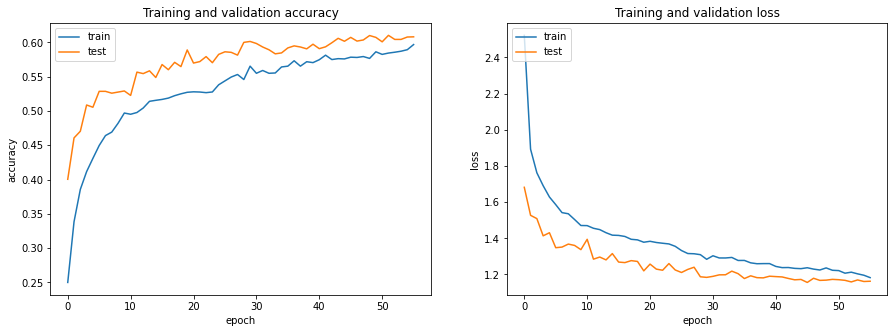

116/116 [==============================] - 24s 200ms/step
              precision    recall  f1-score   support

    Agaricus       0.63      0.65      0.64       354
     Amanita       0.63      0.66      0.64       397
  Armillaria       0.67      0.46      0.54       426
 Cortinarius       0.53      0.58      0.55       363
    Entoloma       0.58      0.58      0.58       345
    Gymnopus       0.55      0.38      0.45       372
   Hygrocybe       0.85      0.85      0.85       360
   Lactarius       0.48      0.59      0.53       378
   Marasmius       0.74      0.67      0.70       366
     Russula       0.50      0.68      0.58       351

    accuracy                           0.61      3712
   macro avg       0.61      0.61      0.61      3712
weighted avg       0.62      0.61      0.61      3712



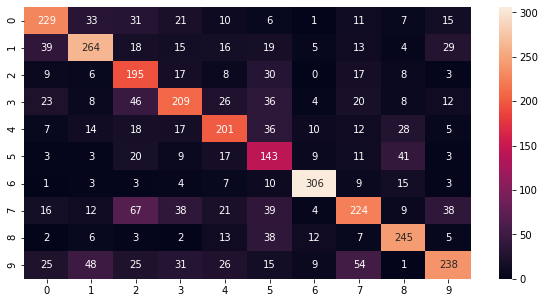

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB0.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B1


In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.01

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable= False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

#on arrive à %

Epoch 1/100
406/406 [==============================] - 117s 270ms/step - loss: 2.5421 - accuracy: 0.2649 - val_loss: 1.7075 - val_accuracy: 0.4114
Epoch 2/100
406/406 [==============================] - 107s 263ms/step - loss: 1.7481 - accuracy: 0.3837 - val_loss: 1.4911 - val_accuracy: 0.4696
Epoch 3/100
406/406 [==============================] - 107s 264ms/step - loss: 1.6573 - accuracy: 0.4154 - val_loss: 1.3989 - val_accuracy: 0.5175
Epoch 4/100
406/406 [==============================] - 107s 263ms/step - loss: 1.6223 - accuracy: 0.4364 - val_loss: 1.4199 - val_accuracy: 0.4938
Epoch 5/100
406/406 [==============================] - 106s 261ms/step - loss: 1.6117 - accuracy: 0.4348 - val_loss: 1.3263 - val_accuracy: 0.5396
Epoch 6/100
406/406 [==============================] - 107s 263ms/step - loss: 1.6049 - accuracy: 0.4384 - val_loss: 1.3609 - val_accuracy: 0.5245
Epoch 7/100
406/406 [==============================] - 107s 263ms/step - loss: 1.5879 - accuracy: 0.4474 - val_loss: 1

58/58 [==============================] - 12s 201ms/step - loss: 1.1705 - accuracy: 0.6072


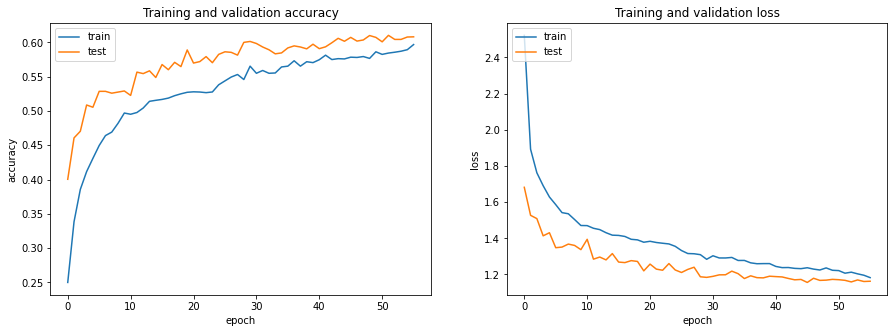

 34/116 [=======>......................] - ETA: 16s

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B2

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(260,260)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs) 

base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.6)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)


callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)
# on arrive à 66%

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
Epoch 1/100
406/406 [==============================] - 121s 280ms/step - loss: 2.5265 - accuracy: 0.2675 - val_loss: 1.6346 - val_accuracy: 0.4127
Epoch 2/100
406/406 [==============================] - 114s 280ms/step - loss: 1.7370 - accuracy: 0.3851 - val_loss: 1.4595 - val_accuracy: 0.4701
Epoch 3/100
406/406 [==============================] - 112s 275ms/step - loss: 1.6181 - accuracy: 0.4317 - val_loss: 1.3790 - val_accuracy: 0.5189
Epoch 4/100
406/406 [==============================] - 113s 277ms/step - loss: 1.5967 - accuracy: 0.4396 - val_loss: 1.3955 - val_accuracy: 0.5175
Epoch 5/100
406/406 [==============================] - 113s 278ms/step - loss: 1.5797 - accuracy: 0.4510 - val_loss: 1.3501 - val_accuracy: 0.5237
Epoch 6/100
406/406 [==============================] - 113s 278ms/step - loss:

58/58 [==============================] - 12s 209ms/step - loss: 1.1196 - accuracy: 0.5991


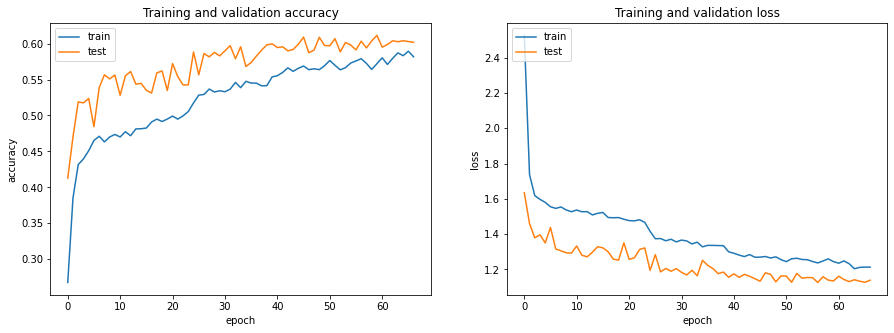

116/116 [==============================] - 25s 201ms/step
              precision    recall  f1-score   support

    Agaricus       0.61      0.64      0.63       354
     Amanita       0.61      0.73      0.67       397
  Armillaria       0.67      0.43      0.52       426
 Cortinarius       0.50      0.63      0.56       363
    Entoloma       0.63      0.54      0.58       345
    Gymnopus       0.52      0.43      0.47       372
   Hygrocybe       0.87      0.75      0.81       360
   Lactarius       0.45      0.59      0.51       378
   Marasmius       0.76      0.69      0.72       366
     Russula       0.55      0.62      0.58       351

    accuracy                           0.60      3712
   macro avg       0.62      0.61      0.61      3712
weighted avg       0.62      0.60      0.60      3712



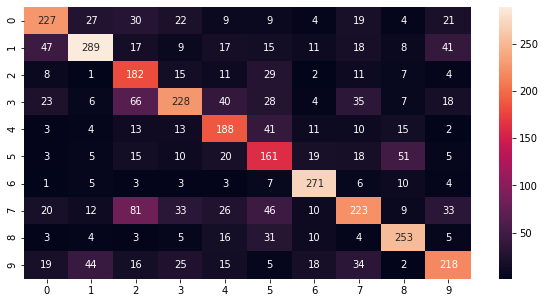

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR  + "ENetB2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B3

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(300,300)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
43941888/43941136 [==============================] - 0s 0us/step
Epoch 1/100
406/406 [==============================] - 135s 312ms/step - loss: 2.3426 - accuracy: 0.2983 - val_loss: 1.6309 - val_accuracy: 0.4459
Epoch 2/100
406/406 [==============================] - 141s 346ms/step - loss: 1.6174 - accuracy: 0.4355 - val_loss: 1.4013 - val_accuracy: 0.5224
Epoch 3/100
406/406 [==============================] - 127s 314ms/step - loss: 1.5247 - accuracy: 0.4698 - val_loss: 1.2870 - val_accuracy: 0.5493
Epoch 4/100
406/406 [==============================] - 126s 311ms/step - loss: 1.4799 - accuracy: 0.4861 - val_loss: 1.3262 - val_accuracy: 0.5485
Epoch 5/100
406/406 [==============================] - 126s 310ms/step - loss: 1.4722 - accuracy: 0.4905 - val_loss: 1.2532 - val_accuracy: 0.5695
Epoch 6/100
4

58/58 [==============================] - 14s 233ms/step - loss: 1.0580 - accuracy: 0.6320


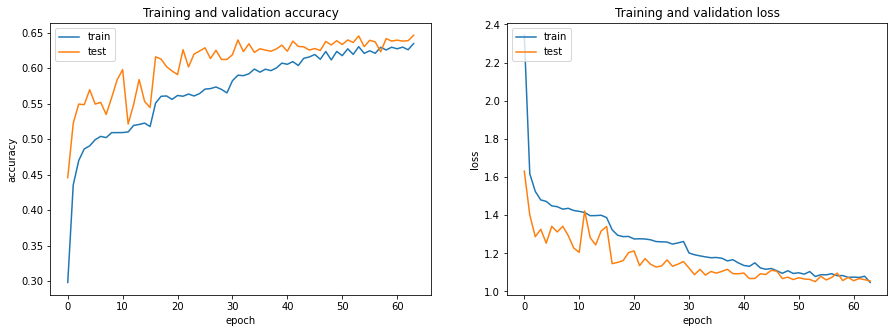

116/116 [==============================] - 27s 220ms/step
              precision    recall  f1-score   support

    Agaricus       0.61      0.69      0.65       354
     Amanita       0.68      0.76      0.72       397
  Armillaria       0.67      0.49      0.56       426
 Cortinarius       0.57      0.61      0.59       363
    Entoloma       0.63      0.63      0.63       345
    Gymnopus       0.60      0.50      0.55       372
   Hygrocybe       0.85      0.84      0.84       360
   Lactarius       0.53      0.57      0.55       378
   Marasmius       0.81      0.67      0.74       366
     Russula       0.56      0.72      0.63       351

    accuracy                           0.65      3712
   macro avg       0.65      0.65      0.65      3712
weighted avg       0.65      0.65      0.64      3712



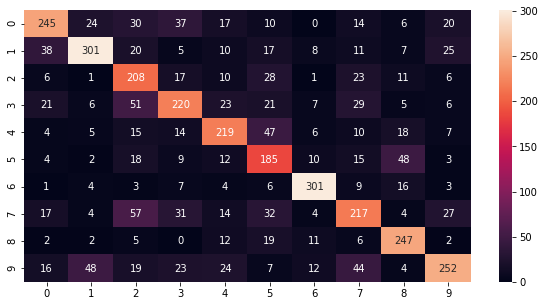

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB3.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B4

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(380,380)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
71688192/71686520 [==============================] - 0s 0us/step
Epoch 1/100
406/406 [==============================] - 168s 387ms/step - loss: 2.3240 - accuracy: 0.3064 - val_loss: 1.5068 - val_accuracy: 0.4679
Epoch 2/100
406/406 [==============================] - 156s 385ms/step - loss: 1.6205 - accuracy: 0.4324 - val_loss: 1.3214 - val_accuracy: 0.5407
Epoch 3/100
406/406 [==============================] - 157s 386ms/step - loss: 1.4898 - accuracy: 0.4788 - val_loss: 1.3289 - val_accuracy: 0.5294
Epoch 4/100
406/406 [==============================] - 156s 385ms/step - loss: 1.4800 - accuracy: 0.4835 - val_loss: 1.2813 - val_accuracy: 0.5579
Epoch 5/100
406/406 [==============================] - 156s 384ms/step - loss: 1.4491 - accuracy: 0.4965 - val_loss: 1.2618 - val_accuracy: 0.5698
Epoch 6/100
4

58/58 [==============================] - 16s 280ms/step - loss: 0.9837 - accuracy: 0.6562


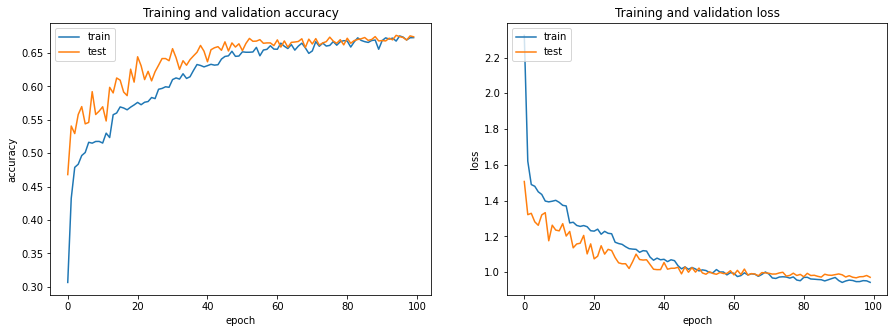

116/116 [==============================] - 30s 239ms/step
              precision    recall  f1-score   support

    Agaricus       0.64      0.73      0.68       354
     Amanita       0.72      0.71      0.71       397
  Armillaria       0.77      0.57      0.66       426
 Cortinarius       0.60      0.65      0.62       363
    Entoloma       0.64      0.68      0.66       345
    Gymnopus       0.57      0.51      0.54       372
   Hygrocybe       0.87      0.85      0.86       360
   Lactarius       0.55      0.67      0.61       378
   Marasmius       0.84      0.68      0.75       366
     Russula       0.62      0.72      0.67       351

    accuracy                           0.67      3712
   macro avg       0.68      0.68      0.68      3712
weighted avg       0.68      0.67      0.68      3712



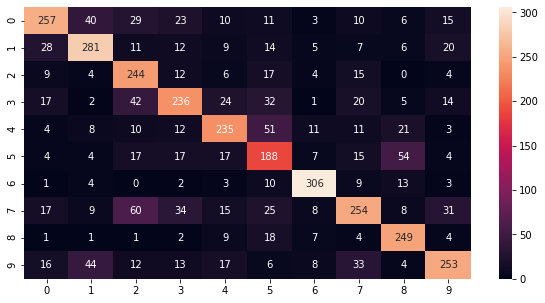

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB4.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B5


In [ ]:
#Model Configuration

IMG_SIZE=(456,456)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable= False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)


Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
115269632/115263384 [==============================] - 2s 0us/step
Epoch 1/100
406/406 [==============================] - 276s 650ms/step - loss: 2.3405 - accuracy: 0.3066 - val_loss: 1.5153 - val_accuracy: 0.4679
Epoch 2/100
406/406 [==============================] - 261s 643ms/step - loss: 1.5628 - accuracy: 0.4520 - val_loss: 1.3137 - val_accuracy: 0.5409
Epoch 3/100
406/406 [==============================] - 261s 642ms/step - loss: 1.4468 - accuracy: 0.4977 - val_loss: 1.2398 - val_accuracy: 0.5687
Epoch 4/100
406/406 [==============================] - 261s 643ms/step - loss: 1.3960 - accuracy: 0.5204 - val_loss: 1.2620 - val_accuracy: 0.5493
Epoch 5/100
406/406 [==============================] - 261s 643ms/step - loss: 1.3780 - accuracy: 0.5206 - val_loss: 1.2674 - val_accuracy: 0.5738
Epoch 6/100

58/58 [==============================] - 28s 482ms/step - loss: 0.8821 - accuracy: 0.7015


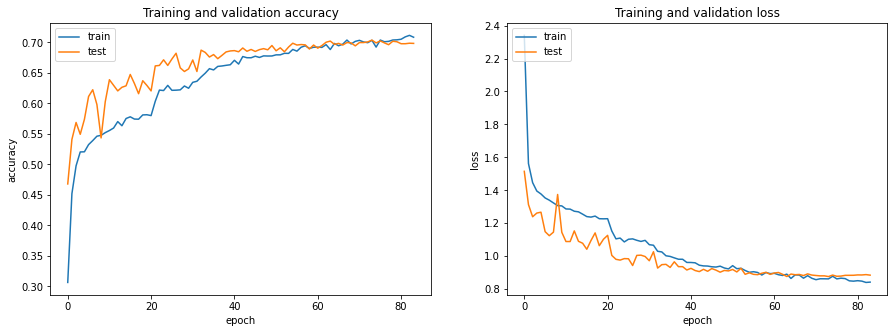

116/116 [==============================] - 55s 458ms/step
              precision    recall  f1-score   support

    Agaricus       0.71      0.75      0.73       354
     Amanita       0.75      0.79      0.77       397
  Armillaria       0.77      0.62      0.68       426
 Cortinarius       0.65      0.63      0.64       363
    Entoloma       0.69      0.67      0.68       345
    Gymnopus       0.57      0.62      0.59       372
   Hygrocybe       0.88      0.86      0.87       360
   Lactarius       0.64      0.63      0.63       378
   Marasmius       0.77      0.76      0.76       366
     Russula       0.64      0.73      0.68       351

    accuracy                           0.70      3712
   macro avg       0.71      0.70      0.70      3712
weighted avg       0.71      0.70      0.70      3712



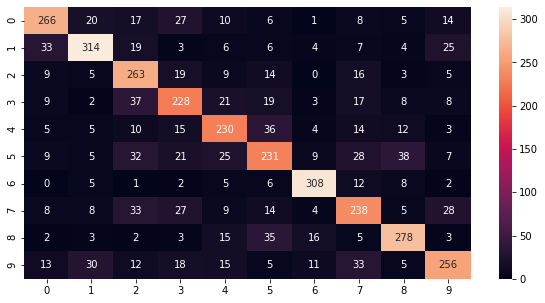

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)


In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB5.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Efficient Net B6

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(528,528)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB6(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
165240832/165234480 [==============================] - 4s 0us/step
Epoch 1/100
406/406 [==============================] - 497s 1s/step - loss: 2.2709 - accuracy: 0.3165 - val_loss: 1.4982 - val_accuracy: 0.4655
Epoch 2/100
406/406 [==============================] - 479s 1s/step - loss: 1.5596 - accuracy: 0.4492 - val_loss: 1.2801 - val_accuracy: 0.5695
Epoch 3/100
406/406 [==============================] - 479s 1s/step - loss: 1.4457 - accuracy: 0.4925 - val_loss: 1.1862 - val_accuracy: 0.5932
Epoch 4/100
406/406 [==============================] - 479s 1s/step - loss: 1.3966 - accuracy: 0.5145 - val_loss: 1.3292 - val_accuracy: 0.5339
Epoch 5/100
406/406 [==============================] - 479s 1s/step - loss: 1.3805 - accuracy: 0.5222 - val_loss: 1.2177 - val_accuracy: 0.5757
Epoch 6/100
406/406 [=====

58/58 [==============================] - 52s 893ms/step - loss: 0.8804 - accuracy: 0.7026


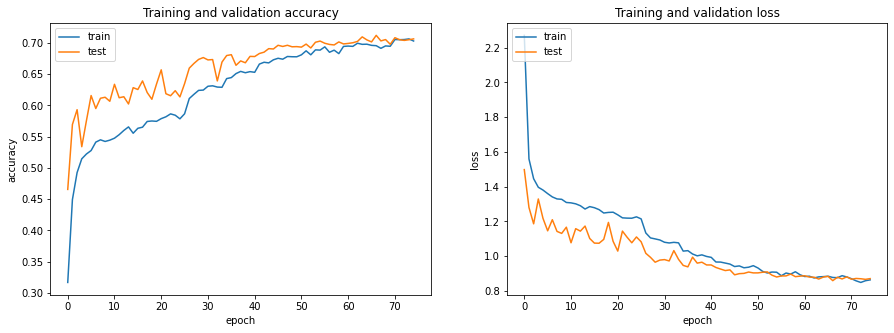

116/116 [==============================] - 103s 864ms/step
              precision    recall  f1-score   support

    Agaricus       0.67      0.77      0.72       354
     Amanita       0.78      0.77      0.77       397
  Armillaria       0.75      0.67      0.71       426
 Cortinarius       0.68      0.62      0.65       363
    Entoloma       0.78      0.61      0.68       345
    Gymnopus       0.58      0.63      0.61       372
   Hygrocybe       0.89      0.89      0.89       360
   Lactarius       0.56      0.70      0.62       378
   Marasmius       0.81      0.75      0.78       366
     Russula       0.71      0.70      0.71       351

    accuracy                           0.71      3712
   macro avg       0.72      0.71      0.71      3712
weighted avg       0.72      0.71      0.71      3712



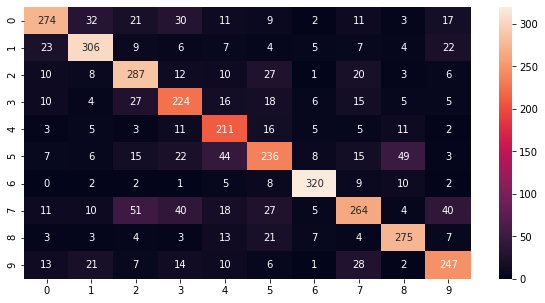

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB6.h5")

#Efficient Net B7

In [ ]:
#Model Configuration
#ATTENTION IL FAUT LA BONNE TAILLE D IMAGE SINON RESULTATS MOINS BONS de 1 à 2 points
IMG_SIZE=(600,600)

preprocess_input=None

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)  
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)
callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
258080768/258076736 [==============================] - 5s 0us/step
Epoch 1/100
406/406 [==============================] - 11225s 28s/step - loss: 2.3241 - accuracy: 0.3134 - val_loss: 1.7194 - val_accuracy: 0.4240
Epoch 2/100
406/406 [==============================] - 424s 1s/step - loss: 1.5442 - accuracy: 0.4564 - val_loss: 1.2259 - val_accuracy: 0.5776
Epoch 3/100
406/406 [==============================] - 423s 1s/step - loss: 1.4063 - accuracy: 0.5078 - val_loss: 1.2695 - val_accuracy: 0.5590
Epoch 4/100
406/406 [==============================] - 424s 1s/step - loss: 1.3688 - accuracy: 0.5212 - val_loss: 1.2208 - val_accuracy: 0.5703
Epoch 5/100
406/406 [==============================] - 423s 1s/step - loss: 1.3503 - accuracy: 0.5270 - val_loss: 1.2225 - val_accuracy: 0.5773
Epoch 6/100
406/406 [==

58/58 [==============================] - 46s 793ms/step - loss: 0.8611 - accuracy: 0.7161


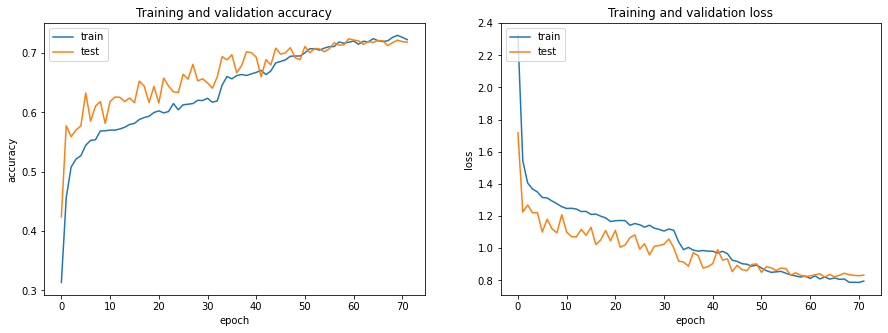

116/116 [==============================] - 93s 762ms/step
              precision    recall  f1-score   support

    Agaricus       0.78      0.74      0.76       354
     Amanita       0.73      0.82      0.77       397
  Armillaria       0.82      0.63      0.71       426
 Cortinarius       0.70      0.66      0.68       363
    Entoloma       0.72      0.65      0.68       345
    Gymnopus       0.59      0.62      0.60       372
   Hygrocybe       0.86      0.90      0.88       360
   Lactarius       0.60      0.73      0.66       378
   Marasmius       0.73      0.77      0.75       366
     Russula       0.71      0.69      0.70       351

    accuracy                           0.72      3712
   macro avg       0.72      0.72      0.72      3712
weighted avg       0.72      0.72      0.72      3712



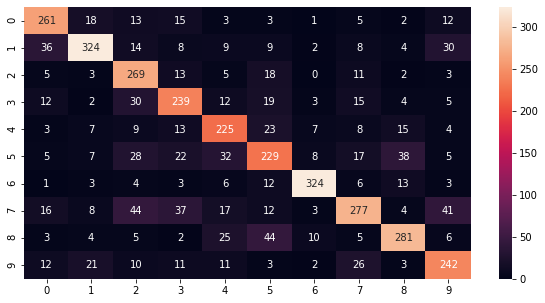

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "ENetB7.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG16

We start with a basic VGG16 

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

pp_input=tf.keras.applications.vgg16.preprocess_input

learning_rate=0.01

epochs=100

In [ ]:

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pp_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=x)
for layer in base_model.layers:
    layer.trainable= False
#build modelb
x = base_model(x, training=False) 
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)
callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/100
406/406 [==============================] - 7239s 18s/step - loss: 2.3651 - accuracy: 0.3000 - val_loss: 1.8115 - val_accuracy: 0.4216
Epoch 2/100
406/406 [==============================] - 112s 275ms/step - loss: 1.7063 - accuracy: 0.4010 - val_loss: 1.5275 - val_accuracy: 0.4768
Epoch 3/100
406/406 [==============================] - 113s 279ms/step - loss: 1.6185 - accuracy: 0.4310 - val_loss: 1.5795 - val_accuracy: 0.4965
Epoch 4/100
406/406 [==============================] - 111s 274ms/step - loss: 1.6005 - accuracy: 0.4393 - val_loss: 1.5847 - val_accuracy: 0.4871
Epoch 5/100
406/406 [==============================] - 112s 277ms/step - loss: 1.5845 - accuracy: 0.4484 - val_loss: 1.5719 - val_accuracy: 0.5013
Epoch 6/100
406/406 [==============================] - 113s 278ms/step - loss: 1.5760 - accuracy: 0.4549 - val_loss: 1.5356 - val_accuracy: 0.5067
Epoch 7/100
406/406 [==============================] - 111s 274ms/step - loss: 1.5781 - accuracy: 0.4503 - val_loss: 1.

58/58 [==============================] - 809s 14s/step - loss: 1.2775 - accuracy: 0.5474


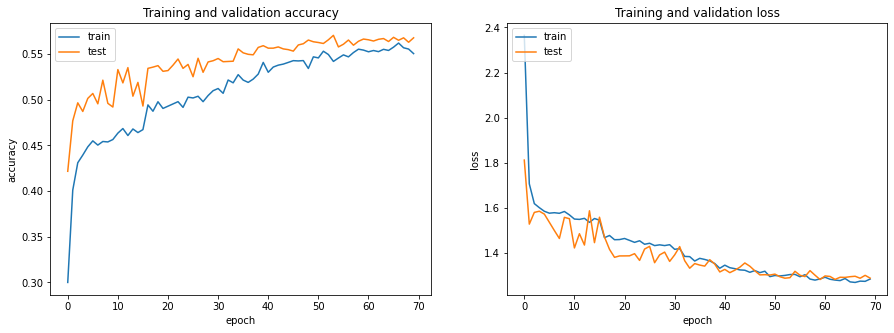

116/116 [==============================] - 22s 191ms/step
              precision    recall  f1-score   support

    Agaricus       0.50      0.60      0.54       354
     Amanita       0.54      0.68      0.60       397
  Armillaria       0.61      0.43      0.50       426
 Cortinarius       0.51      0.55      0.53       363
    Entoloma       0.65      0.47      0.54       345
    Gymnopus       0.51      0.47      0.49       372
   Hygrocybe       0.78      0.86      0.82       360
   Lactarius       0.43      0.46      0.44       378
   Marasmius       0.69      0.63      0.66       366
     Russula       0.51      0.54      0.53       351

    accuracy                           0.57      3712
   macro avg       0.57      0.57      0.57      3712
weighted avg       0.57      0.57      0.56      3712



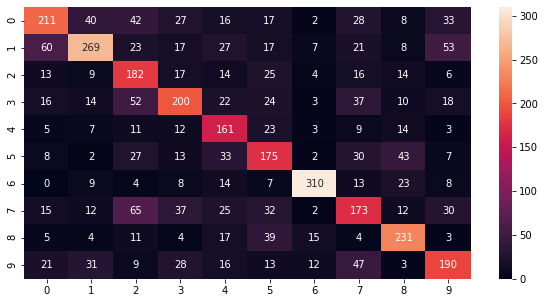

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)


In [ ]:
model.save(MODEL_DIR + "VGG16.h5")

#VGG19

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

pp_input=tf.keras.applications.vgg19.preprocess_input

learning_rate=0.01

epochs=100

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pp_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=x)
for layer in base_model.layers:
    layer.trainable= False
#build modelb
x = base_model(x) 
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = tf.math.exp(-0.5)
   , patience = 5  
   , min_lr = 0.0000
   , verbose = 1
)
callback = [reduceLEarningRate_clbck, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

# => on arrive à % 

80142336/80134624 [==============================] - 0s 0us/step
Epoch 1/100
406/406 [==============================] - 116s 281ms/step - loss: 2.3656 - accuracy: 0.3013 - val_loss: 1.6674 - val_accuracy: 0.4502
Epoch 2/100
406/406 [==============================] - 114s 281ms/step - loss: 1.7029 - accuracy: 0.4006 - val_loss: 1.5005 - val_accuracy: 0.4978
Epoch 3/100
406/406 [==============================] - 114s 280ms/step - loss: 1.6133 - accuracy: 0.4323 - val_loss: 1.5227 - val_accuracy: 0.5016
Epoch 4/100
406/406 [==============================] - 113s 279ms/step - loss: 1.6098 - accuracy: 0.4355 - val_loss: 1.4859 - val_accuracy: 0.5040
Epoch 5/100
406/406 [==============================] - 114s 280ms/step - loss: 1.5926 - accuracy: 0.4430 - val_loss: 1.5228 - val_accuracy: 0.4790
Epoch 6/100
406/406 [==============================] - 114s 280ms/step - loss: 1.5835 - accuracy: 0.4440 - val_loss: 1.4989 - val_accuracy: 0.5000
Epoch 7/100
406/406 [==============================] 

58/58 [==============================] - 13s 221ms/step - loss: 1.3575 - accuracy: 0.5560


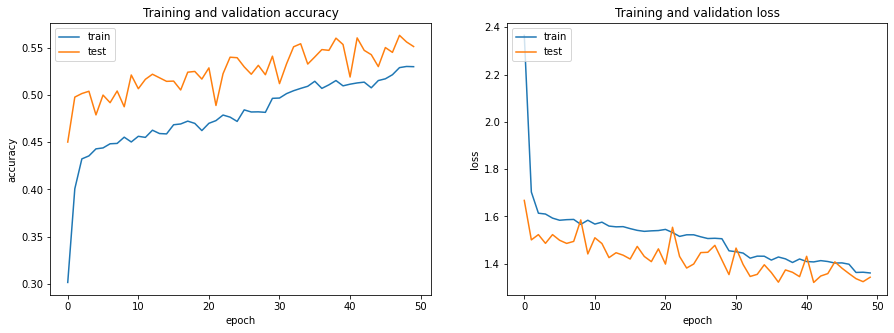

116/116 [==============================] - 23s 199ms/step
              precision    recall  f1-score   support

    Agaricus       0.49      0.62      0.55       354
     Amanita       0.53      0.69      0.60       397
  Armillaria       0.59      0.46      0.51       426
 Cortinarius       0.58      0.54      0.56       363
    Entoloma       0.56      0.48      0.52       345
    Gymnopus       0.48      0.39      0.43       372
   Hygrocybe       0.77      0.84      0.80       360
   Lactarius       0.46      0.40      0.43       378
   Marasmius       0.59      0.72      0.65       366
     Russula       0.54      0.48      0.51       351

    accuracy                           0.56      3712
   macro avg       0.56      0.56      0.56      3712
weighted avg       0.56      0.56      0.55      3712



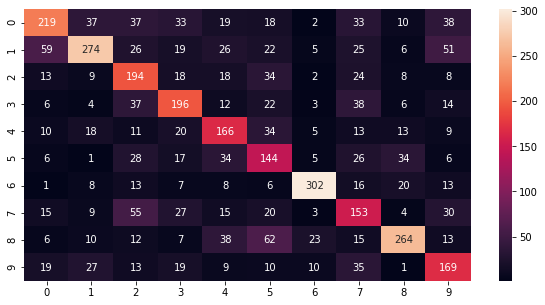

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model, history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "VGG19.h5")

#Xception 

In [ ]:
#Model Configuration

IMG_SIZE=(299,299)

preprocess_input=tf.keras.applications.xception.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

# => on arrive à %

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/100
406/406 [==============================] - 130s 312ms/step - loss: 2.3228 - accuracy: 0.3044 - val_loss: 1.8216 - val_accuracy: 0.3739
Epoch 2/100
406/406 [==============================] - 127s 312ms/step - loss: 1.6591 - accuracy: 0.4186 - val_loss: 1.5215 - val_accuracy: 0.4704
Epoch 3/100
406/406 [==============================] - 126s 311ms/step - loss: 1.5695 - accuracy: 0.4500 - val_loss: 1.4626 - val_accuracy: 0.4865
Epoch 4/100
406/406 [==============================] - 129s 318ms/step - loss: 1.5416 - accuracy: 0.4601 - val_loss: 1.4542 - val_accuracy: 0.4941
Epoch 5/100
406/406 [==============================] - 128s 316ms/step - loss: 1.5254 - accuracy: 0.4622 - val_loss: 1.4123 - val_accuracy: 0.5178
Epoch 6/100
4

58/58 [==============================] - 14s 243ms/step - loss: 1.2250 - accuracy: 0.5738


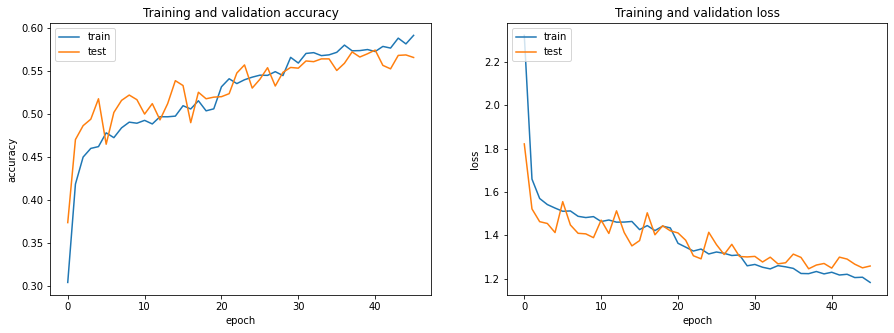

116/116 [==============================] - 25s 214ms/step
              precision    recall  f1-score   support

    Agaricus       0.56      0.56      0.56       354
     Amanita       0.55      0.69      0.61       397
  Armillaria       0.64      0.50      0.56       426
 Cortinarius       0.47      0.57      0.51       363
    Entoloma       0.51      0.53      0.52       345
    Gymnopus       0.48      0.43      0.45       372
   Hygrocybe       0.80      0.82      0.81       360
   Lactarius       0.49      0.48      0.49       378
   Marasmius       0.74      0.66      0.70       366
     Russula       0.53      0.48      0.51       351

    accuracy                           0.57      3712
   macro avg       0.58      0.57      0.57      3712
weighted avg       0.58      0.57      0.57      3712



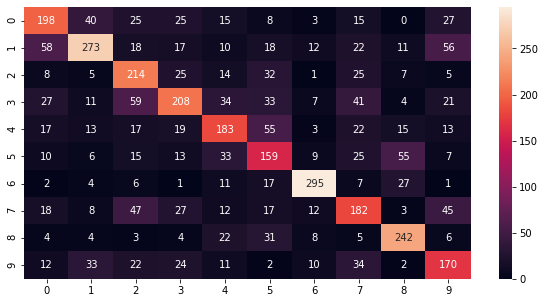

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "xception.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#MobileNet V2

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input= tf.keras.applications.mobilenet_v2.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)


#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

#fit
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)



Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/100
406/406 [==============================] - 108s 258ms/step - loss: 2.3325 - accuracy: 0.3144 - val_loss: 1.6244 - val_accuracy: 0.4351
Epoch 2/100
406/406 [==============================] - 103s 254ms/step - loss: 1.6680 - accuracy: 0.4153 - val_loss: 1.5504 - val_accuracy: 0.4617
Epoch 3/100
406/406 [==============================] - 103s 254ms/step - loss: 1.5902 - accuracy: 0.4399 - val_loss: 1.5206 - val_accuracy: 0.4725
Epoch 4/100
406/406 [==============================] - 104s 255ms/step - loss: 1.5606 - accuracy: 0.4527 - val_loss: 1.5747 - val_accuracy: 0.4607
Epoch 5/100
406/406 [==============================] - 102s 252ms/step - loss: 1.5579 - accuracy: 0.4615 - val_loss: 1.5237 - val_accuracy: 0.4701
Epoch 6/100
406

58/58 [==============================] - 12s 200ms/step - loss: 1.3939 - accuracy: 0.5178


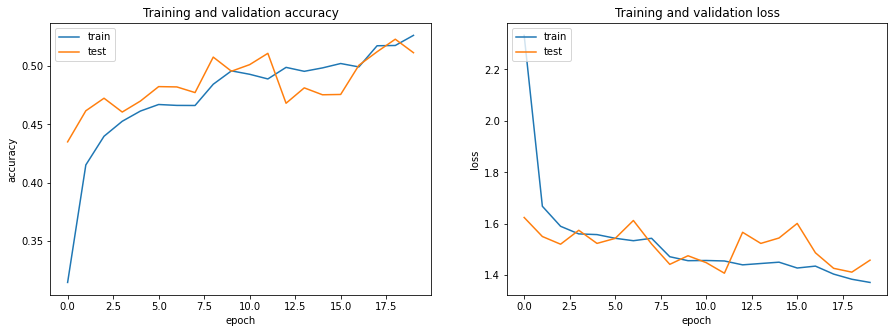

116/116 [==============================] - 23s 196ms/step
              precision    recall  f1-score   support

    Agaricus       0.47      0.48      0.48       354
     Amanita       0.48      0.60      0.53       397
  Armillaria       0.60      0.36      0.45       426
 Cortinarius       0.37      0.67      0.48       363
    Entoloma       0.51      0.48      0.49       345
    Gymnopus       0.60      0.20      0.30       372
   Hygrocybe       0.75      0.80      0.77       360
   Lactarius       0.44      0.39      0.41       378
   Marasmius       0.68      0.61      0.65       366
     Russula       0.44      0.55      0.49       351

    accuracy                           0.51      3712
   macro avg       0.53      0.51      0.50      3712
weighted avg       0.53      0.51      0.50      3712



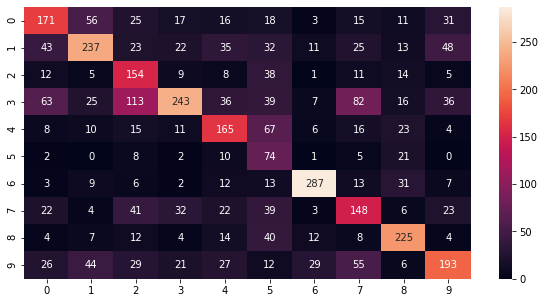

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "mobileNetv2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#ResNet 50

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=tf.keras.applications.resnet50.preprocess_input

learning_rate=0.01

datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)

IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                    ])
x= data_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) # inference mode : batch normalization layers are not trainable if model.trainable=True
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation= "LeakyReLU" )(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])


history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Found 12992 validated image filenames belonging to 10 classes.
Found 3712 validated image filenames belonging to 10 classes.
Found 1856 validated image filenames belonging to 10 classes.
31793152/31790344 [==============================] - 0s 0us/step
Epoch 1/100
406/406 [==============================] - 122s 283ms/step - loss: 2.4912 - accuracy: 0.2528 - val_loss: 1.6419 - val_accuracy: 0.4219
Epoch 2/100
406/406 [==============================] - 113s 279ms/step - loss: 1.7992 - accuracy: 0.3707 - val_loss: 1.6143 - val_accuracy: 0.4356
Epoch 3/100
406/406 [==============================] - 112s 277ms/step - loss: 1.7202 - accuracy: 0.3971 - val_loss: 1.5511 - val_accuracy: 0.4496
Epoch 4/100
406/406 [==============================] - 111s 274ms/step - loss: 1.6968 - accuracy: 0.4108 - val_loss: 1.5361 - val_accuracy: 0.4666
Epoch 5/100
406/406 [==============================] - 113s 279ms/step - loss: 1.6752 - accuracy: 0.4210 - val_loss: 1.5202 - val_accuracy: 0.4776
Epoch 6/100
4

58/58 [==============================] - 12s 210ms/step - loss: 1.3467 - accuracy: 0.5307


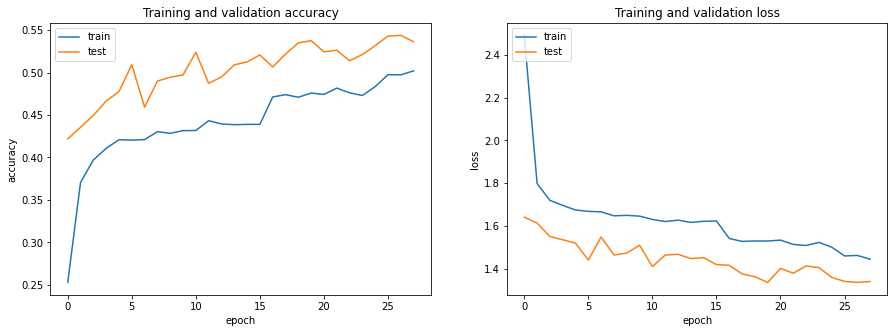

116/116 [==============================] - 25s 207ms/step
              precision    recall  f1-score   support

    Agaricus       0.51      0.47      0.49       354
     Amanita       0.54      0.64      0.59       397
  Armillaria       0.52      0.58      0.55       426
 Cortinarius       0.48      0.54      0.51       363
    Entoloma       0.58      0.41      0.48       345
    Gymnopus       0.39      0.47      0.43       372
   Hygrocybe       0.76      0.84      0.80       360
   Lactarius       0.42      0.47      0.45       378
   Marasmius       0.89      0.46      0.61       366
     Russula       0.50      0.47      0.48       351

    accuracy                           0.54      3712
   macro avg       0.56      0.54      0.54      3712
weighted avg       0.56      0.54      0.54      3712



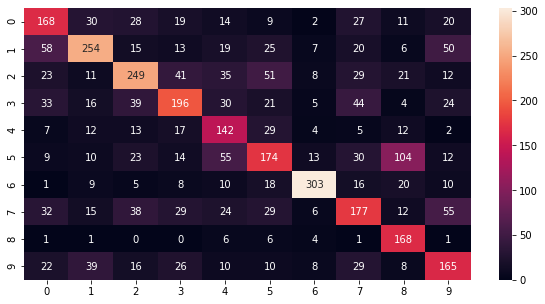

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model, history)

In [ ]:
# Finally Save the entire optimized model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(MODEL_DIR + "resnet50.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Diagnostics functions

In [ ]:
#show model performance
def show_performance(my_model,history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  x_epochs=range(len(history.history["accuracy"]))
  plt.plot(x_epochs, history.history["accuracy"])
  plt.plot(x_epochs, history.history["val_accuracy"])
  plt.title("Training and validation accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  x_epochs=range(len(history.history["loss"]))
  plt.plot(x_epochs, history.history["loss"])
  plt.plot(x_epochs, history.history["val_loss"])
  plt.title("Training and validation loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes
  print(metrics.classification_report(y_test_class, test_pred_class, target_names=list_genus))
  df_cm=pd.DataFrame(metrics.confusion_matrix(test_pred_class,y_test_class))
  plt.figure(figsize = (10,5))
  sns.heatmap(df_cm, annot=True, fmt="d")


In [ ]:
def show_good_predictions(preprocess_input):
  
  correct_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] == y_test_class[i]):
      correct_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(correct_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))

In [ ]:
#Show wrong predictions
def show_wrong_predictions(my_model, test_generator):
  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes

  error_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] != y_test_class[i]):
      error_indexes.append(i)
  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(error_indexes, size=5):
    #img=cv2.imread(X_test.img_path.iloc[i])
    img=tf.io.read_file(test_generator.filenames[i])
    img=tf.image.decode_jpeg(img,channels=3)
    plt.subplot(1,5,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(list_genus[y_test_class[i]]) +
              "\n"+ "Prediction:" + str(list_genus[test_pred_class[i]]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))
    print("Path: ", test_generator.filenames[i])


#SUMMARY

In [ ]:
#list all h5 models in a main directory
os.listdir(MODEL_DIR)

['efficientnetb0.h5',
 'efficientnetb1.h5',
 'efficientnetb2.h5',
 'efficientnetb3.h5',
 'efficientnetb4.h5',
 'efficientnetb5.h5',
 'vgg16.h5',
 'vgg19.h5',
 'xception.h5',
 'resnet50.h5',
 'efficientnetb6.h5',
 'mobilenetv2.h5',
 'efficientnetb7.h5']

In [ ]:
#Prepare the image test set for model evaluation

df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

filtre_genus=df_genus.taxon_name.value_counts().index[:10]
print(filtre_genus)
t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125, random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)


Index(['Amanita', 'Armillaria', 'Hygrocybe', 'Lactarius', 'Agaricus',
       'Gymnopus', 'Cortinarius', 'Russula', 'Marasmius', 'Entoloma'],
      dtype='object')
shape :  (27080, 39)
shape X genus:  (18560, 2)
shape train:  (12992, 2)
shape test: (3712, 2)
shape valid:  (1856, 2)


In [ ]:
#Model calibration
#load models from file
def load_all_models():
    all_models = {}
    filenames = [MODEL_DIR + file for file in os.listdir(MODEL_DIR)]
    for file in filenames:
            model = tf.keras.models.load_model(file)
            name = file.replace(MODEL_DIR, "")
            # add to list of members
            all_models[name]=model
            print('>Loading model %s' % file)
    return all_models


# load all models   
members = load_all_models()
print('Loaded %d models' % len(members))

results={}

for name, model in members.items():
    print("\n Analyzing ", name)
    IMG_SIZE= model.input.get_shape().as_list()[1:3]
    if "efficientnet" in name:
        preprocess_input = None
    elif "vgg16" in name:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
    elif "vgg19" in name:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
    elif "xception" in name:
        preprocess_input = tf.keras.applications.xception.preprocess_input
    elif "mobilenetv2" in name:
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    elif "resnet50" in name:
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    else :
        raise NameError('No preprocess input specified') 

    datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
    #test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
    #                                        x_col="img_path", y_col="taxon_name", shuffle=False,
    #                                        class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    # evaluate standalone models on test dataset
    metrics = model.evaluate(val_generator)  #renvoi plusieurs scalars selon le nb de métrique choisies : loss, accuracy,..
    results[name] = metrics
    print('Model Accuracy: %.3f' % metrics[1])

    del model

pd.DataFrame(results, index=["Loss","Accuracy"]).T.drop("Loss", axis=1)

>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb0.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb1.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb2.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb3.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb4.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb5.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/vgg16.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/vgg19.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/xception.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/resnet50.h5
>Loading model /content/drive/MyDrive/work/Oliv/saved_model/10 genus_2k/efficientnetb6.h5
>Loading model /content/drive/MyDrive/wo

,Accuracy
efficientnetb0.h5,0.601832
efficientnetb1.h5,0.593750
efficientnetb2.h5,0.599138
efficientnetb3.h5,0.632004
efficientnetb4.h5,0.656250
efficientnetb5.h5,0.701509
vgg16.h5,0.547414
vgg19.h5,0.556035
xception.h5,0.573815
resnet50.h5,0.530711
